In [38]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math


In [150]:
img_dir = "./data/downloaded/ericcahan/Nashville, TN - Sunset 6:59pm.jpg"

In [151]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})
    

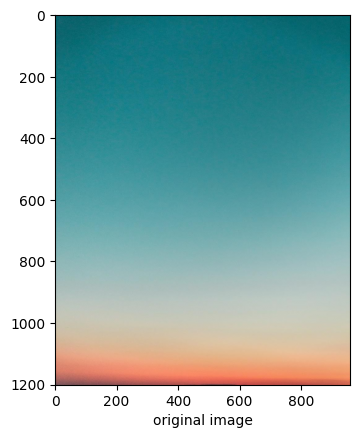

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


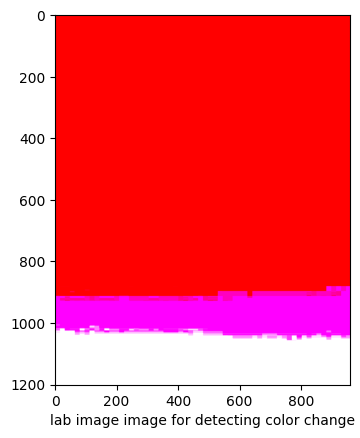

Rotation angle: -32.87518932707628


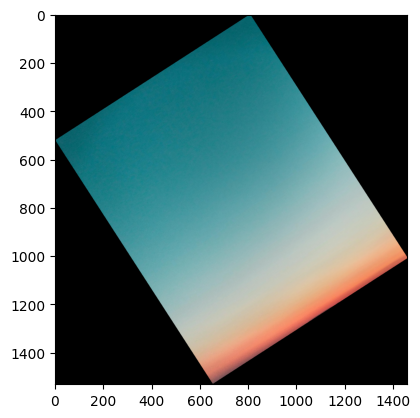

-32.87518932707628

In [153]:
from scipy.ndimage import sobel
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from skimage.feature import canny

def detect_color_change_degree(img):
    """
    Detects the direction of the color change in an image.
    """
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    # image = image.rotate(35, expand=True)

     # show the lab image
    plt.imshow(image)
    plt.xlabel("original image")
    plt.show()


    
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Convert the image to LAB color space for better color difference representation
    lab_image = color.rgb2lab(image_array)

    # show the lab image
    plt.imshow(lab_image)
    plt.xlabel("lab image image for detecting color change")
    plt.show()

    # Calculate gradients in the a* and b* channels
    gradient_kernel = np.array([[1, 0, -1]])
    gradient_a = convolve2d(lab_image[:, :, 1], gradient_kernel, mode="same", boundary="wrap")
    gradient_b = convolve2d(lab_image[:, :, 2], gradient_kernel, mode="same", boundary="wrap")

    # Compute gradient magnitudes
    gradient_magnitudes = np.sqrt(gradient_a**2 + gradient_b**2)

    # Define a weighting function (e.g., square of gradient magnitude)
    weights = gradient_magnitudes ** 2

    # Compute weighted mean gradient direction
    mean_gradient_direction = np.sum(np.arctan2(gradient_b, gradient_a) * weights) / np.sum(weights)

    # Convert the mean gradient direction to degrees
    rotation_angle_deg = np.degrees(mean_gradient_direction)
    
    rotated_image = image.rotate(-rotation_angle_deg, expand=True)

    plt.imshow(rotated_image)
    plt.show()

    # Get the rotated image data as a NumPy array
    rotated_image_array = np.array(rotated_image)

    non_black_mask = np.all(rotated_image_array != [0, 0, 0], axis=-1)

    # Apply the mask to the rotated image array
    cropped_rotated_array = rotated_image_array[non_black_mask]

    # Convert the cropped rotated image array to an image
    cropped_rotated_image = Image.fromarray(cropped_rotated_array.astype('uint8'))

    image_data = get_df_rgb(cropped_rotated_array)
    

    return rotation_angle_deg

detect_color_change_degree(img_dir)

In [88]:
from scipy import ndimage

def align_image(image, rotation_angle):
    # Convert the image to a NumPy array
    image = image
    if isinstance(image, str):
        image = Image.open(image)
    image_array = np.array(image)
    # Rotate the image to align the color gradient vertically
    rotation_angle_rad = np.radians(rotation_angle)
    aligned_image = ndimage.rotate(image_array, rotation_angle, reshape=True, mode='constant', cval=0)

    # Flatten the image along the vertical axis
    flattened_image = np.mean(aligned_image, axis=0)

    # Create a new image from the flattened representation
    flattened_image = Image.fromarray(flattened_image.astype('uint8'))

    return flattened_image

align_image(img_dir, detect_color_change_degree(img_dir)).show()

Rotation angle: 6.869089413344622e-06


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable radians method

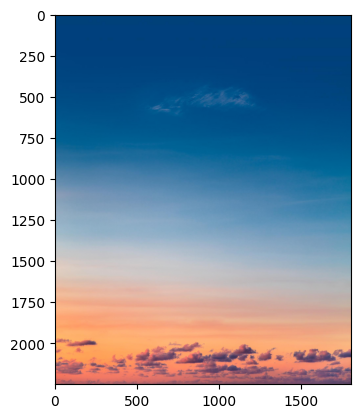

(4050000, 3)


In [4]:
File_name = mpimg.imread(img_dir)
plt.imshow(File_name)
plt.show()

# plt.imshow(image)
# image.show()
rgb_values = get_df_rgb(File_name)
print(rgb_values.shape)

In [5]:
rgb_array = rgb_values.values

# Initialize the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to your data
pca.fit(rgb_array)

# Transform the RGB values to the first two principal components
pca_components = pca.transform(rgb_array)


Sort rgb values according to pca_1 value

In [6]:
pca_1 = pca_components[:,0]
sorted_pca_1_indices = np.argsort(pca_1)
sorted_pca_1 = pca_1[sorted_pca_1_indices]
sorted_pca_colors = rgb_array[sorted_pca_1_indices]

In [50]:
num_colors = 5

min_pca_value = sorted_pca_1[0]
max_pca_value = sorted_pca_1[-1]

pca_value_stops = np.linspace(min_pca_value, max_pca_value, num_colors + 1)

previous_value = min_pca_value  # Initialize with the minimum value
accumulated_count = 0

sections = []
for i, value in enumerate(pca_value_stops):
    if i == 0:
        continue
    else:
        condition = None
        if i == len(pca_value_stops) - 1:
            condition = (previous_value <= pca_1) & (pca_1 <= value)
        else:
            condition = (previous_value <= pca_1) & (pca_1 < value)
        pca_values_in_section = pca_1[condition]
        original_indices = np.array(range(len(pca_values_in_section))) + accumulated_count

        sections.append({
            "pca_values": pca_values_in_section,
            "original_indices": original_indices,
        })
        print(f"Section {i}: {previous_value} to {value}")
        print(f"Number of images: {len(pca_values_in_section)}")
        print()
        accumulated_count += len(pca_values_in_section)
        previous_value = value  # Update previous_section for the next iteration



Section 1: -117.41512578128506 to -60.57369767356573
Number of images: 1705370

Section 2: -60.57369767356573 to -3.7322695658464085
Number of images: 354541

Section 3: -3.7322695658464085 to 53.10915854187293
Number of images: 466411

Section 4: 53.10915854187293 to 109.95058664959224
Number of images: 499441

Section 5: 109.95058664959224 to 166.79201475731153
Number of images: 1024237



In [51]:
print(sections[-1]["original_indices"][-1])

4049999


In [52]:
# sections[0]["pca_values"]
sections[0]["original_indices"]

array([      0,       1,       2, ..., 1705367, 1705368, 1705369])

In [53]:
key_colors = []


for i in range(len(sections)):
    section = sections[i]
    original_indices = section['original_indices']
    median_index = int(len(original_indices) / 2)
    original_index = original_indices[median_index]
    key_colors.append(rgb_array[original_index])

    
print(key_colors)


[array([  0,  69, 128], dtype=uint8), array([ 25, 112, 157], dtype=uint8), array([ 85, 144, 178], dtype=uint8), array([203, 197, 197], dtype=uint8), array([255, 165, 116], dtype=uint8)]


In [54]:
def create_color_gradient_key_colors(key_colors, gradient_width, gradient_height):
    # gradient_colors = calculate_intermediate_colors(key_colors, len(key_colors))
    gradient_colors = [tuple(color) for color in key_colors]
    
    gradient_palette = Image.new("RGB", (gradient_width, gradient_height))
    draw = ImageDraw.Draw(gradient_palette)
    
    color_width = gradient_width / len(gradient_colors)
    for i, color in enumerate(gradient_colors):
        draw.rectangle([(i * color_width, 0), ((i + 1) * color_width, gradient_height)], fill=color)
    
    return gradient_palette


In [55]:
gradient_image = create_color_gradient_key_colors(key_colors, 1000, 100)
gradient_image.show()

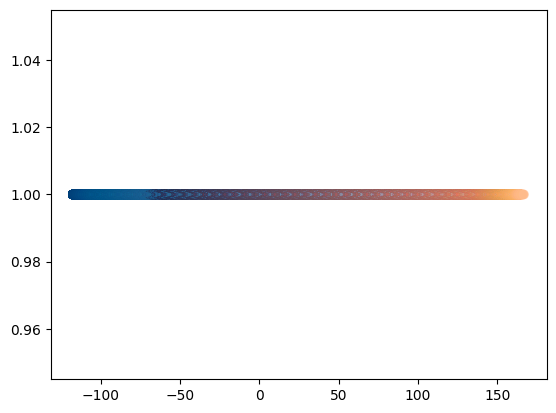

In [72]:
# Check if the sorted works well
one_dim = pca_components[:, 0]
# plt.scatter(one_dim, np.zeros_like(one_dim), c=rgb_array/255.0, alpha=0.5)
plt.scatter(sorted_pca_1, np.ones_like(sorted_pca_1), c=sorted_pca_colors/255.0, alpha=0.5)
plt.show()


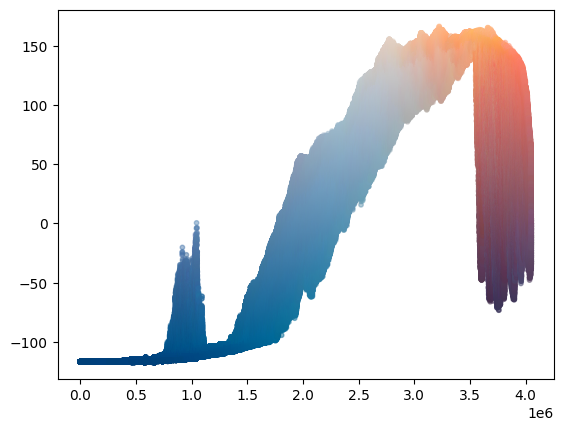

In [71]:
plt.scatter(range(len(one_dim)), one_dim, c=rgb_array/255.0, alpha=0.5, s=10)
plt.show()

In [ ]:
print(pca_components)

In [ ]:
len(pca_components)
first_component = pca_components[:, 0]
first_component.shape

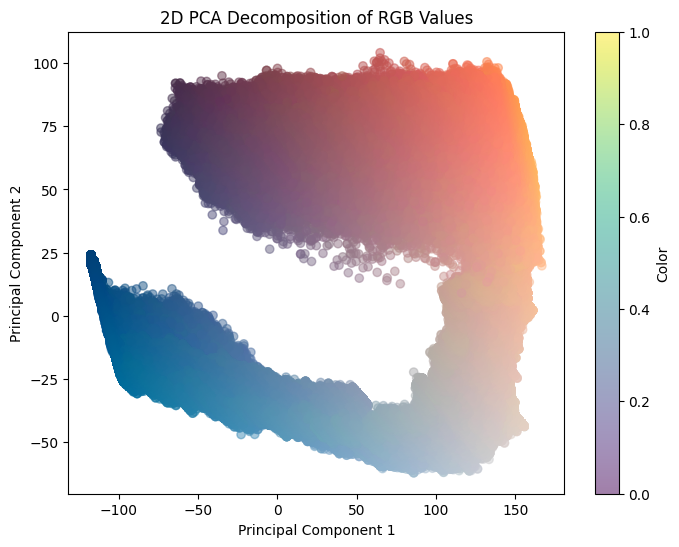

In [69]:
# Create a DataFrame for the transformed PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Plot the 2D PCA decomposition with colored points
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=rgb_array/255.0, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Decomposition of RGB Values')
plt.colorbar(label='Color')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

palette_size = 5
model = KMeans(n_clusters=palette_size)
clusters = model.fit_predict(rgb_values)

palette = model.cluster_centers_.astype(int).tolist()

In [ ]:
ndArray = np.array(palette, dtype=np.float32)
outImg = Image.fromarray(ndArray)
# outImg.save('./image.jpg')
print(ndArray)


In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 1))

# Set axis limits
ax.set_xlim(0, len(palette))
ax.set_ylim(0, 1)

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Create colored squares for each RGB value
for i, rgb in enumerate(palette):
    color = [comp / 255.0 for comp in rgb]  # Normalize to [0, 1] range
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Display the color row
plt.show()

In [76]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean


def calculate_intermediate_colors(colors, num_colors):
    gradient_colors = []
    
    for i in range(num_colors):
        t = i / (num_colors - 1)
        interpolated_color = tuple(int(colors[0][c] * (1 - t) + colors[1][c] * t) for c in range(3))
        gradient_colors.append(interpolated_color)
    
    return gradient_colors

def extract_key_colors_kmeans(image_path, num_colors):
    image = Image.open(image_path)
    image_array = np.array(image)

    
    h, w, d = image_array.shape
    image_flatten = image_array.reshape(h * w, d)
    # Initialize the PCA model with 1 component
    pca_1 = PCA(n_components=1)
    # Fit the PCA model to your data
    pca_1.fit(image_flatten)
    # Transform the RGB values to the first one principal component
    pca_1_components = pca_1.transform(image_flatten)
    
    sorted_pca_1_indices = np.argsort(pca_1_components[:, 0])
    sorted_pca_1 = pca_1_components[sorted_pca_1_indices]

    # sort the colors by the pca_1_components
    image_flatten = image_flatten[sorted_pca_1_indices]

    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(image_flatten)
    cluster_centers = kmeans.cluster_centers_

    key_colors = []

    temp_colors = []
    for i in range(num_colors):
        cluster_pts = image_flatten[kmeans.labels_ == i]
        cluster_pts_indices = np.where(kmeans.labels_ == i)[0]
        cluster_cen = cluster_centers[i]
        cluster_mean = np.mean(cluster_pts, axis=0)
    
        # min_idx = np.argmin([euclidean(image_flatten[idx], cluster_cen) for idx in cluster_pts_indices])
        # temp_colors.append({
        #     "idx": cluster_pts_indices[min_idx],
        #     "color": image_flatten[cluster_pts_indices[min_idx]]
        # })
        # key_colors.append(image_flatten[cluster_pts_indices[min_idx]])
        print(cluster_mean)
        key_colors.append(cluster_mean.astype(int))
    
    # temp_colors = sorted(temp_colors, key=lambda x: x["idx"])
    # print(temp_colors)
    # key_colors = [color["color"] for color in temp_colors]

    # key_colors = cluster_centers.astype(int)

    
    return key_colors

def create_color_gradient_key_colors(key_colors, gradient_width, gradient_height):
    # gradient_colors = calculate_intermediate_colors(key_colors, len(key_colors))
    gradient_colors = [tuple(color) for color in key_colors]
    
    gradient_palette = Image.new("RGB", (gradient_width, gradient_height))
    draw = ImageDraw.Draw(gradient_palette)
    
    color_width = gradient_width / len(gradient_colors)
    for i, color in enumerate(gradient_colors):
        draw.rectangle([(i * color_width, 0), ((i + 1) * color_width, gradient_height)], fill=color)
    
    return gradient_palette

# input_image_path = "./data/downloaded/ericcahan/Alamar, Ciudad De La Habana, Cuba - Sunset 8:11pm.jpg"
# input_image_path = "./data/Lenna.png"
output_gradient_width = 1000
output_gradient_height = 100
num_colors_in_gradient = 5

key_colors = extract_key_colors_kmeans(img_dir, num_colors_in_gradient)
gradient_image = create_color_gradient_key_colors(key_colors, output_gradient_width, output_gradient_height)
gradient_image.show()

[  0  65 121]
[  0  63 124]


/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[  3.2995581   78.26719093 134.25165851]
[178.2841129  183.97729718 192.23299365]
[240.74002232 163.6999762  126.47955636]
[ 88.14056264 139.79832568 177.4323309 ]
[151.03896385  91.80726245 105.94310138]
